# QML Project

```
AUTHORS
Charlie BROSSE  
Guillaume CARRIERE  
Marius DUBOSC
```

L'objectif du projet et de reproduire les circuits et les résultats obtenus dans le papier "Polyadic Quantum Classifier" (https://arxiv.org/abs/2007.14044)

In [3]:
!pip3 install qiskit --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.0 MB/s eta 0:00:0000:0100:01
  Created wheel for qiskit: filename=qiskit-0.40.0-py3-none-any.whl size=12823 sha256=ad5a1a912619c030e3f8d46c08a9e9b1be29b54b11a389ca3ee7ac2a9e654d7d
  Stored in directory: /home/guillaume/.cache/pip/wheels/c5/00/ef/b840aa2b1f36f5d392fc563ce3c992fb54d1a4d6ea0c29dc00
Successfully built qiskit
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.22.4
    Uninstalling qiskit-terra-0.22.4:
      Successfully uninstalled qiskit-terra-0.22.4
  Attempting uninstall: qiskit
    Found existing installation: qiskit 0.39.5
    Uninstalling qiskit-0.39.5:
      Successfully uninstalled qiskit-0.39.5


In [4]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
import time
from qiskit.providers.ibmq.managed import IBMQJobManager

qs = qiskit.Aer.get_backend('qasm_simulator')

# Useful functions

## Preprocessing functions

These functions correspond to the data encoding functions from the original paper.

In [5]:
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

def rescaleFeature(x, alpha, q):
    return (1-alpha/2) * (np.pi/q) * standardise(x)

## Circuit functions

This is a function to construct a basic psi gate, as described in the paper.

In [6]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

# Quantum Classifier Class

This is the loss function described in the paper. Only relevant bitstrings are taken into account.

In [7]:
def logSoftmax(label, job_results, bitstrings, nshots) :
    if label in job_results :
        e = np.exp(job_results[label] / nshots)
    else :
        e = 1
        
    s = 0
    for bitstring in bitstrings :
        if bitstring in job_results :
            s += np.exp(job_results[bitstring] / nshots)
        else :
            s += 1 
            
    return -np.log(e / s)


This is our main class which we will use to train an predict. By default we will use COBYLA and our previously defined loss to train.

In [8]:
class QuantumClassifier:

    def __init__(self, circuit_builder, bitstrings, theta_size, loss_function = logSoftmax, optimizer_method = "COBYLA"):
        self.circuit_builder = circuit_builder
        self.circuit=None
        self.bitstrings = bitstrings
        self.theta_size = theta_size
        self.loss_function = loss_function
        self.optimizer_method = optimizer_method
        self.theta = None
        self.nshots = 100
        
    
    # Training functions
    def executeJob(self, circuit):
        job = qiskit.execute(circuit, shots=self.nshots, backend=qs)
        return job.result().get_counts()
    
    def build_circuit(self, theta, X):
        omega = X
        self.circuit = self.circuit_builder(theta, omega)
        return self.circuit

    def runCircuit(self, theta, X, y):
        self.build_circuit(theta, X)
        job_results = self.executeJob(self.circuit)
        label = y
        return self.loss_function(label, job_results, self.bitstrings, self.nshots)
    
    def runIBM(self, X, theta, backend):
        circuit_list=[self.build_circuit(theta, X_el) for X_el in X]
        circs = qiskit.transpile(circuit_list, backend=backend)
        job_manager = IBMQJobManager()
        job_set = job_manager.run(circs, backend=backend, nam='iris')
        while(job_set.statuses()[0].name != 'DONE'):
            time.sleep(0.1)
            
        return job_set.results()
        
    def lossBatch(self, theta, X, y, backend=None):
    
        total_loss = 0

        batch = list(zip(X, y))

        if backend is None:
            for X_el, y_el in zip(X, y) :
                total_loss += self.runCircuit(theta, X_el, y_el)
        else:
            results = self.runIBM(X, theta, backend)
            for i in range(len(y)):
                total_loss+=self.loss_function(y[i], results.get_counts(i), self.bitstrings, self.nshots)

        total_loss /= len(y)
        print("loss: " + str(total_loss))
        return total_loss
        
    def fit(self, X, y, nshots=100, maxiter=20, theta=None, backend=None):
        
        if theta is not None:
            self.theta = theta
            
        if self.theta is None:
            self.theta = np.random.uniform(0, 2 * np.pi, self.theta_size)            
            
        self.nshots = nshots

        opt = sp.optimize.minimize(
            fun=lambda params : self.lossBatch(params, X, y, backend),
            x0=self.theta,
            method=self.optimizer_method,
            options={'maxiter': maxiter}
        )
        
        self.theta = opt.x
        
        return opt
    
    # Testing functions
    def argmaxJobResults(self, job_results):
        max_label_value = None
        max_label = None
    
        for label in job_results :
            if label in self.bitstrings and (max_label_value is None or job_results[label] >= max_label_value) :
                max_label = label
                max_label_value = job_results[label]
        return max_label
    
    def predict(self, X, theta=None, nshots=100, backend=None):
        
        if theta is not None:
            self.theta = theta
            
        self.nshots = nshots
        
        y_pred = []
        
        if backend is None:
            for omega in X :    
                self.circuit = self.circuit_builder(self.theta, omega)
                job_results = self.executeJob(self.circuit)
                y_pred.append(self.argmaxJobResults(job_results))
        else :
            results = self.runIBM(X, self.theta, backend)
            y_pred = [self.argmaxJobResults(results.get_counts(i)) for i in range(len(X))]

        return y_pred

    def compute_accuracy(self, y_pred, y) :
        correct = 0

        for y_pred_el, y_el in zip(y_pred, y) :
            if y_pred_el == y_el :
                correct += 1
        
        return correct / len(y)

# I - IRIS

## Construct dataset

### Import dataset

In [68]:
df_iris = pd.read_csv("iris.data")
df_iris

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Preprocess

Preprocessing consists in computing the encoding function of the paper. We will use a fixed q value of 3 and alpha value of 1/10 as done in the paper.

In [69]:
alpha = 0.1
q = 3

attributes = df_iris.columns[:-1]

for x in attributes:
    df_iris[x] = rescaleFeature(df_iris[x], alpha, q)

df_iris

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,Iris-setosa
1,-1.137116,-0.124313,-1.334348,-1.306199,Iris-setosa
2,-1.378201,0.336104,-1.390920,-1.306199,Iris-setosa
3,-1.498743,0.105896,-1.277776,-1.306199,Iris-setosa
4,-1.016574,1.256938,-1.334348,-1.306199,Iris-setosa
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,Iris-virginica
146,0.550477,-1.275354,0.702249,0.917304,Iris-virginica
147,0.791562,-0.124313,0.815393,1.048098,Iris-virginica
148,0.429934,0.796521,0.928537,1.440481,Iris-virginica


We will attribute each class to the bistrings 00, 01 and 10. Thus, 11 will remain unused.

In [70]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10"
}

df_iris = df_iris.replace({"class": diconvert})
df_iris

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,00
1,-1.137116,-0.124313,-1.334348,-1.306199,00
2,-1.378201,0.336104,-1.390920,-1.306199,00
3,-1.498743,0.105896,-1.277776,-1.306199,00
4,-1.016574,1.256938,-1.334348,-1.306199,00
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,10
146,0.550477,-1.275354,0.702249,0.917304,10
147,0.791562,-0.124313,0.815393,1.048098,10
148,0.429934,0.796521,0.928537,1.440481,10


In [71]:
X_iris = df_iris[attributes].values
y_iris = df_iris["class"].values

### Split

We will use a training size of 90 samples and a test size of 60 samples as done in the paper.

In [72]:
train_size = 90
test_size = 60

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=test_size, train_size=train_size, stratify=y_iris)

## Circuit

In [73]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    iris_circuit = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : iris_circuit.cz(0, 1)
        psiGate(iris_circuit, omega[(2*i) % 4], 0)
        psiGate(iris_circuit, omega[(2*i+1) % 4], 1)
        
        iris_circuit.cz(0, 1)
        
        psiGate(iris_circuit, theta[(2*i)], 0)
        psiGate(iris_circuit, theta[(2*i+1)], 1)
        
    qc.append(iris_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

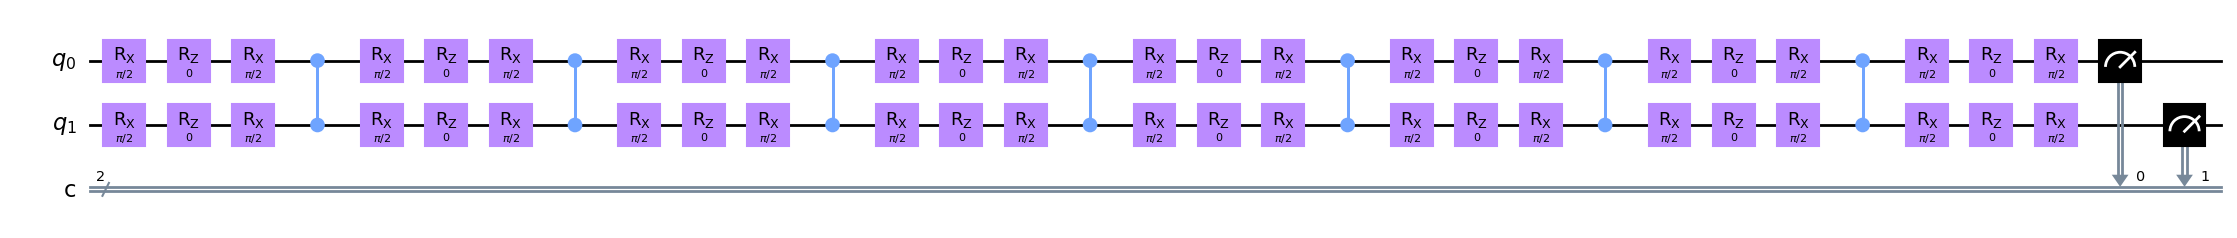

In [74]:
irisCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [80]:
iris_classifier = QuantumClassifier(irisCircuit, ['00', '01', '10'], 8)

In [81]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=250, maxiter=20)

loss: 1.2735323887045151
loss: 1.1718801236186907
loss: 1.2324405340367024
loss: 1.2664346979741157
loss: 1.1175406555889311
loss: 1.0622498453135347
loss: 1.0151486614861684
loss: 1.0900066905803163
loss: 1.1250377506786045
loss: 1.072620888236843
loss: 1.0501957989193778
loss: 1.0094022336828274
loss: 1.0103526952067445
loss: 1.0052971009731828
loss: 0.9878345183303362
loss: 0.9903551566248611
loss: 1.0402254418535222
loss: 0.9618354100470838
loss: 0.9607524617519037
loss: 0.9679968865653854


In [82]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=500, maxiter=30)

loss: 0.9582465901801178
loss: 1.0749028486341663
loss: 0.9225626244540264
loss: 0.9756631756863803
loss: 0.8941148847725875
loss: 0.9974574588160832
loss: 0.9207587440156678
loss: 0.952636218491907
loss: 0.972632147152224
loss: 0.9213298321935598
loss: 0.8948012494546044
loss: 0.9092861114082177
loss: 0.9225709160238295
loss: 0.8959439697128706
loss: 0.9016683857201802
loss: 0.8952412853696875
loss: 0.8939307737628386
loss: 0.8839615049469335
loss: 0.8861760824655706
loss: 0.886726441271685
loss: 0.8814864336914114
loss: 0.8856103238641917
loss: 0.8754753700558717
loss: 0.8783047197799196
loss: 0.8738613866808768
loss: 0.8876659097431598
loss: 0.8899400979426036
loss: 0.8762545708943167
loss: 0.88116571935026
loss: 0.8779008366868327


In [83]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=750, maxiter=70)

loss: 0.876087515889859
loss: 0.9597645831695871
loss: 0.9232370550543325
loss: 0.9770083615475934
loss: 0.9514096450230225
loss: 0.9825744968415844
loss: 0.939544385807174
loss: 0.909012848569127
loss: 0.9325982462654478
loss: 0.8839914774612132
loss: 0.8808756725655738
loss: 0.8832185742613766
loss: 0.8771032150065217
loss: 0.8816933938312472
loss: 0.8783723917710413
loss: 0.8879624058368214
loss: 0.8851629078513827
loss: 0.8696139982143529
loss: 0.8718292404512002
loss: 0.8709858145089162
loss: 0.872345472016939
loss: 0.8703716739403131
loss: 0.8634314748415421
loss: 0.8665661379366972
loss: 0.8718919387615423
loss: 0.8597393437424097
loss: 0.8679341581692708
loss: 0.8617380900317626
loss: 0.8557310420140997
loss: 0.8644489629426474
loss: 0.8559947734671935
loss: 0.8522501792626871
loss: 0.8543380157373588
loss: 0.854031093395401
loss: 0.8505953248897408
loss: 0.8538295574063759
loss: 0.858256278489285
loss: 0.8531383809742759
loss: 0.8528479946353666
loss: 0.8531001510212997
loss: 

## Compute results

In [84]:
y_pred_iris = iris_classifier.predict(X_train_iris, nshots=1000)
iris_classifier.compute_accuracy(y_pred_iris, y_train_iris)

0.7555555555555555

In [88]:
y_pred_iris = iris_classifier.predict(X_test_iris, nshots=1000)
iris_classifier.compute_accuracy(y_pred_iris, y_test_iris)

0.8833333333333333

We obtain a precision of 88,3%, which is pretty good, but this result can fluctuate.

# II - Gaussian XOR

## Construct dataset

### Generate dataset

The training dataset is generated by sampling points from 2D gaussian distributions centered around key points. These key points will be on the cartesian axes. Points from the x-axis will have label 0 and points from the y-axis will have label 1.

The testing dataset will simply be the whole space.

In [39]:
import numpy as np
import math

In [40]:
def generate_gaussian_point(x, y) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return [pick_x, pick_y]

In [41]:
center1 = (-np.pi / 2, 0)
center2 = (np.pi / 2, 0)
center3 = (0, -np.pi / 2)
center4 = (0, np.pi / 2)

centers = [center1, center2, center3, center4]


In [42]:
X_train_xor = []
y_train_xor = []

for i in range(20) :
    X_train_xor.append(generate_gaussian_point(*center1))
    y_train_xor.append(0)
    
    X_train_xor.append(generate_gaussian_point(*center2))
    y_train_xor.append(0)
    
    X_train_xor.append(generate_gaussian_point(*center3))
    y_train_xor.append(1)
    
    X_train_xor.append(generate_gaussian_point(*center4))
    y_train_xor.append(1)
    
X_train_xor = np.array(X_train_xor)
y_train_xor = np.array(y_train_xor)

In [43]:
lin = np.linspace(-np.pi, np.pi, num = 50)
X_test_xor = np.array([[x, y] for x in lin for y in lin])

y_test_xor = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test_xor]

(-3.141592653589793, 3.141592653589793)

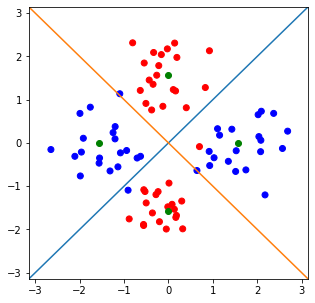

In [44]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

c = ["blue" if el==0 else "red" for el in y_train_xor]

plt.scatter(X_train_xor[:, 0], X_train_xor[:, 1], color=c)

x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

### Preprocess

We will attribute each class to the bistrings 00 and 10. Thus, 01 and 11 will remain unused.

In [45]:
diconvert = {
    0 : "00",
    1 : "10",
}

new_y_train_xor = [diconvert[x] for x in y_train_xor]
new_y_test_xor = [diconvert[x] for x in y_test_xor]

y_train_xor = new_y_train_xor
y_test_xor = new_y_test_xor

y_train_xor[:10]

['00', '00', '10', '10', '00', '00', '10', '10', '00', '00']

## Circuit

In [46]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    xor_circuit = qiskit.QuantumCircuit(2)
    
    psiGate(xor_circuit, omega[0], 0)
    psiGate(xor_circuit, omega[1], 1)
    
    for i in range(2):
        xor_circuit.cz(0, 1)
        psiGate(xor_circuit, theta[2*i], 0)
        psiGate(xor_circuit, theta[2*i+1], 1)
        
    
    qc.append(xor_circuit, range(2))
    qc.measure(range(2), range(2))
    return qc

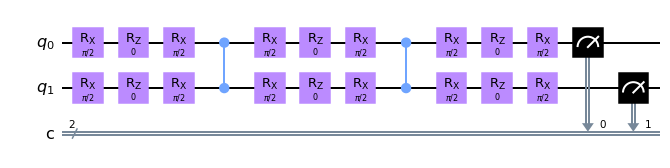

In [47]:
xorCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [48]:
xor_classifier = QuantumClassifier(xorCircuit, ['00', '10'], 4)

In [49]:
xor_opt = xor_classifier.fit(X_train_xor, y_train_xor, nshots=250, maxiter=80)
xor_opt

loss: 0.7258457305201179
loss: 0.6577982315198929
loss: 0.6208488846070925
loss: 0.6731241301079912
loss: 0.664806747621615
loss: 0.5862289066318775
loss: 0.607732042243055
loss: 0.55781323357923
loss: 0.5397164853359713
loss: 0.5346650813535125
loss: 0.5221365439977059
loss: 0.554938353109352
loss: 0.518467925793018
loss: 0.5118523284247681
loss: 0.5339804163210923
loss: 0.5172506169110445
loss: 0.5208285262857524
loss: 0.5129082301774803
loss: 0.5104780020135531
loss: 0.5144783199389562
loss: 0.5087814431429829
loss: 0.5116065608964562
loss: 0.513524971848329
loss: 0.5105337115994203
loss: 0.5094860267769701
loss: 0.5093445344190037
loss: 0.510285718875054
loss: 0.5105418658201838
loss: 0.5110383984523172
loss: 0.5098688408108125
loss: 0.5107305288859396
loss: 0.5124210419711661
loss: 0.5091949798243057
loss: 0.5100179021563832
loss: 0.5123897549164438
loss: 0.5102960861684803
loss: 0.5115018496143354
loss: 0.5085178184522583
loss: 0.5106540511164247
loss: 0.5105232831093257
loss: 0.

     fun: 0.5115081166024869
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 53
  status: 1
 success: True
       x: array([7.95974666, 6.45291286, 1.54828324, 3.24947226])

## Compute results

In [50]:
y_pred_xor = xor_classifier.predict(X_train_xor)
xor_classifier.compute_accuracy(y_pred_xor, y_train_xor)

0.9625

In [51]:
y_pred_xor = xor_classifier.predict(X_test_xor)

(-3.141592653589793, 3.141592653589793)

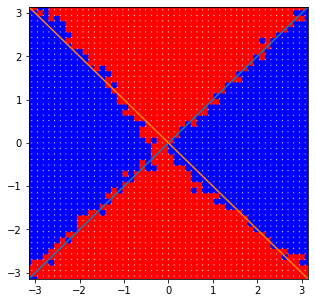

In [52]:
plt.rcParams['figure.figsize'] = [5,5]


c = ["blue" if el=="00" else "red" for el in y_pred_xor]
plt.scatter(X_test_xor[:, 0], X_test_xor[:, 1], color=c)

x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [53]:
xor_classifier.compute_accuracy(y_pred_xor, y_test_xor)

0.9372

## Compare with GaussianNB

In [54]:
from sklearn.naive_bayes import GaussianNB

In [55]:
gaussianNb = GaussianNB()

y_train_bayes = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_train_xor]

gaussianNb.fit(X_train_xor, y_train_bayes)

y_test_bayes = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test_xor]

score = gaussianNb.score(X_test_xor, y_test_bayes)

In [56]:
score

0.9252

We obtained a precision of 94,7%, on par with the Bayes classifier's precision of 94.7%. This result can also fluctuate.

# III - Skin segmentation

## Construct dataset

### Import dataset

In [57]:
df_skin = pd.read_csv("Skin_NonSkin.txt", sep='\t', header=None)
df_skin

,0,1,2,3
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
245052,163,162,112,2
245053,163,162,112,2
245054,163,162,112,2
245055,163,162,112,2


### Preprocess

In [58]:
alpha = 0.1
q = 3

attributes = df_skin.columns[:-1]

for x in attributes:
    df_skin[x] = rescaleFeature(df_skin[x], alpha, q)

df_skin

,0,1,2,3
0,-0.816021,-0.788476,-0.002429,1
1,-0.832001,-0.805073,-0.016139,1
2,-0.847981,-0.821670,-0.029849,1
3,-0.879941,-0.854863,-0.057269,1
4,-0.879941,-0.854863,-0.057269,1
...,...,...,...,...
245052,0.606191,0.489488,-0.153241,2
245053,0.606191,0.489488,-0.153241,2
245054,0.606191,0.489488,-0.153241,2
245055,0.606191,0.489488,-0.153241,2


We will attribute each class to the bistrings 000, 111. Every other bitstring will remain unused.

In [59]:
diconvert = {
    1 : "000",
    2 : "111"
}

df_skin = df_skin.replace({3: diconvert})
df_skin

,0,1,2,3
0,-0.816021,-0.788476,-0.002429,000
1,-0.832001,-0.805073,-0.016139,000
2,-0.847981,-0.821670,-0.029849,000
3,-0.879941,-0.854863,-0.057269,000
4,-0.879941,-0.854863,-0.057269,000
...,...,...,...,...
245052,0.606191,0.489488,-0.153241,111
245053,0.606191,0.489488,-0.153241,111
245054,0.606191,0.489488,-0.153241,111
245055,0.606191,0.489488,-0.153241,111


In [60]:
X_skin = df_skin[attributes].values
y_skin = df_skin[3].values

### Split

We will use a training size of 600 samples and a test size of 400 samples as done in the paper.

In [61]:
train_size = 600
test_size = 400

X_train_skin, X_test_skin, y_train_skin, y_test_skin = train_test_split(X_skin, y_skin, test_size=test_size, train_size=train_size, stratify=y_skin)

## Circuit

In [62]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3, 3)
    
    skin_seg_circuit = qiskit.QuantumCircuit(3)
    psiGate(skin_seg_circuit, omega[0], 0)
    psiGate(skin_seg_circuit, omega[1], 1)
    psiGate(skin_seg_circuit, omega[2], 2)
    
    skin_seg_circuit.cz(0, 2)
    
    psiGate(skin_seg_circuit, theta[0], 0)
    psiGate(skin_seg_circuit, theta[1], 2)
    
    skin_seg_circuit.cz(0, 1)
    
    psiGate(skin_seg_circuit, theta[2], 0)
    psiGate(skin_seg_circuit, theta[3], 1)
    
    skin_seg_circuit.cz(1, 2)
    
    psiGate(skin_seg_circuit, theta[4], 1)
    psiGate(skin_seg_circuit, theta[5], 2)
    
    qc.append(skin_seg_circuit, range(3))
    qc.measure(range(3), range(3))
    
    return qc

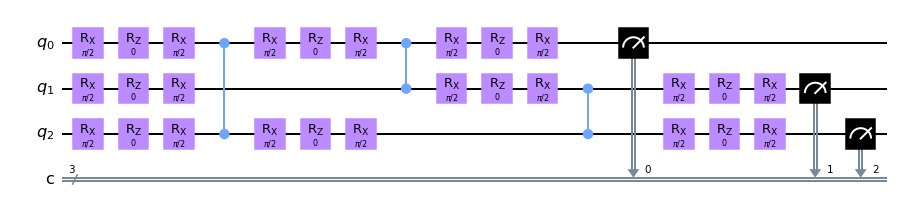

In [63]:
skinSegCircuit(np.zeros(6), np.zeros(3)).decompose().draw("mpl", fold=40)

## Train

We will use COBYLA as optimizer for this training. BFGS was used in the original paper instead, but without exact gradients this optimizer would require a very high number of shots to be efficient which would make the training too slow.

In [64]:
skin_classifier = QuantumClassifier(skinSegCircuit, ['000', '111'], 6, optimizer_method = "COBYLA")

In [66]:
opt_skin = skin_classifier.fit(X_train_skin, y_train_skin, nshots=250, maxiter=30)
opt_skin

## Compute results

In [67]:
y_pred_skin = skin_classifier.predict(X_train_skin)
skin_classifier.compute_accuracy(y_pred_skin, y_train_skin)

0.7366666666666667

In [68]:
y_pred_skin = skin_classifier.predict(X_test_skin)
skin_classifier.compute_accuracy(y_pred_skin, y_test_skin)

0.6825

We obtain a precision of 68,25%. This is not bad but it could be improved by using BFGS as in the paper.

# IV - Synthetic dataset with 4 classes

## Construct dataset

### Generate dataset

We generate the dataset with sklearn, with only 2 informative features, 1 cluster per class and 4 classes.

In [89]:
from sklearn.datasets import make_classification

X_synth, y_synth = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=4)

### Preprocess

In [90]:
alpha = 0.1
q = 3


X_synth[:, 0] = rescaleFeature(X_synth[:, 0], alpha, q)
X_synth[:, 1] = rescaleFeature(X_synth[:, 1], alpha, q)

X_synth[:10]

array([[-0.48105927, -0.94012249],
       [ 1.82432392,  1.29209659],
       [-0.64114358,  1.81674148],
       [-0.35054608, -0.76026123],
       [ 0.56049085,  0.64096446],
       [ 0.23999089,  0.63096973],
       [-0.01753069, -0.16814032],
       [ 1.67697975, -1.528278  ],
       [-1.31424283, -0.67963376],
       [-0.70409178,  1.04484101]])

We will attribute each class to the bistrings 00, 01, 10 and 11. No bitstring is unused.

In [91]:
new_y_synth = []

diconvert = {
    0 : "00",
    1 : "01",
    2 : '10',
    3 : '11'
}

for el in y_synth:
    new_y_synth.append(diconvert[el])

y_synth = new_y_synth

y_synth[:10]

['00', '11', '10', '00', '11', '11', '00', '01', '00', '10']

### Split

We will use a train/test ratio of 60%/40% as done in the paper.

In [92]:
train_size = 0.6
test_size = 0.4

X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=test_size, train_size=train_size, stratify=y_synth)

## Circuit

In [93]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)

    synthetic_circuit = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, omega[0], 0)
        psiGate(synthetic_circuit, omega[1], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i)], 0)
        psiGate(synthetic_circuit, theta[(6*i+1)], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, omega[0], 0)
        psiGate(synthetic_circuit, omega[1], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i+2)], 0)
        psiGate(synthetic_circuit, theta[(6*i+3)], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i+4)], 0)
        psiGate(synthetic_circuit, theta[(6*i+5)], 1)
    
    qc.append(synthetic_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

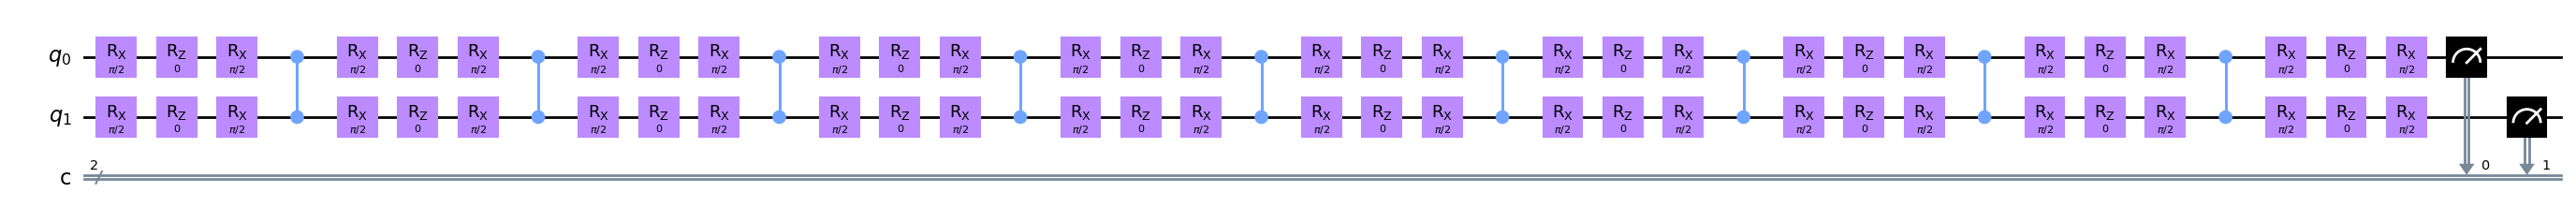

In [94]:
syntheticCircuit(np.zeros(12), np.zeros(2)).decompose().draw("mpl", fold=50)

## Train

We will use COBYLA as optimizer for this training. As for the skin dataset, BFGS would be better but would require too many shots.

In [95]:
synthetic_classifier = QuantumClassifier(syntheticCircuit, ['00', '01', '10', '11'], 12, optimizer_method = "COBYLA")

In [96]:
opt_synth = synthetic_classifier.fit(X_train_synth, y_train_synth, nshots=250, maxiter=40)
opt_synth

loss: 1.4871223246173728
loss: 1.4210641598127753
loss: 1.3063556890093992
loss: 1.3452629676540522
loss: 1.3858179181811339
loss: 1.3020274039525834
loss: 1.3222149667010876
loss: 1.3622520516851049
loss: 1.3291663944241858
loss: 1.2459230680006481
loss: 1.3737820669263845
loss: 1.316444554805441
loss: 1.3608410209168214
loss: 1.2189819252462595
loss: 1.157942189609667
loss: 1.1655953039324776
loss: 1.3097536346240544
loss: 1.2235889033400897
loss: 1.1650479047644
loss: 1.2063455900118774
loss: 1.1759814912224618
loss: 1.2234566685112553
loss: 1.2316910812311528
loss: 1.1525267526661702
loss: 1.1823715496842095
loss: 1.179470289544929
loss: 1.17009436807286
loss: 1.1249108462484099
loss: 1.1168902244942396
loss: 1.1222848344425524
loss: 1.1601900306589563
loss: 1.1109672503581924
loss: 1.1265762879836616
loss: 1.1264779152114377
loss: 1.1016645613540035
loss: 1.1108316035429486
loss: 1.0916840289493208
loss: 1.096546963755504
loss: 1.101899940613543
loss: 1.1135420208000428


     fun: 1.0916840289493208
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 40
  status: 2
 success: False
       x: array([ 4.44825143,  4.23248732,  4.0832701 ,  0.74946064,  6.34959451,
        2.82910597,  2.09313152,  3.31518235,  6.84195882,  1.60020483,
       -0.6278217 ,  3.0467222 ])

## Compute results

In [97]:
y_pred_synth = synthetic_classifier.predict(X_train_synth)
synthetic_classifier.compute_accuracy(y_pred_synth, y_train_synth)

0.695

In [98]:
y_pred_synth = synthetic_classifier.predict(X_test_synth)
synthetic_classifier.compute_accuracy(y_pred_synth, y_test_synth)

0.695

We obtain 69,5%, which is not bad. As for the skin dataset, performance could be improved by using BFGS.

# V - Run on IBM Quantum Computer

Let's now run our circuits on simulated quantum computer, by using the IMBQ API. After registering an account, we can access the API with a Token.

In [99]:
TOKEN = "a9e80916023230fb39159420e5dd02f5b990b0b0b6de16364350b822082c4c8b2fefa2195d742c878f71f8d7771c103c2204729cffbf56145670d539c15e9dda"
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())
# backend = provider.get_backend('ibmq_qasm_simulator')

/tmp/ipykernel_22522/2595094723.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  qiskit.IBMQ.save_account(TOKEN, overwrite=True)


Once we obtain a provider as backend, we can run jobs on it. These jobs must be quantum circuits. Since we need to go through the entire dataset at each epoch, we can't submit a job for each sample, it would be way too long ; instead, we use a Tob Manager.

The Job Manager is a higher level mechanism for handling jobs composed of multiple circuits or pulse schedules. It splits the experiments into multiple jobs based on backend restrictions. When the jobs are finished, it collects and presents the results in a unified view.

As you can see in the *runIBM* method of the *QuantumClassifier* class, we begin by appending each circuit (for each sample) into a list, which we transpile and run as jobs with the job manager. When each job has ended, we can retrieve the result of each circuit, to compute the total loss.

## IRIS

In [77]:
iris_ibm_classifier = QuantumClassifier(irisCircuit, ['00', '01', '10'], 8)

In [78]:
opt_iris = iris_ibm_classifier.fit(X_train_iris, y_train_iris, nshots=250, maxiter=20, backend=backend)

loss: 4.3432731499152375
loss: 7.106845242708028
loss: 4.748980323617045
loss: 2.734088358411447
loss: 1.1741608002113495
loss: 2.3964203144751717
loss: 2.126426575991026
loss: 1.7850628534850308
loss: 1.9843705450735971
loss: 1.0596032847869952
loss: 1.0775144029694108
loss: 1.151930591456416
loss: 0.8256277486638354
loss: 0.7163466490088382
loss: 0.6201073092729932
loss: 0.714060766964724
loss: 0.5291756803290667
loss: 0.7371780232686089
loss: 0.7878848130843072
loss: 0.37207902382358315


In [79]:
y_pred_iris_ibm = iris_ibm_classifier.predict(X_test_iris, backend=backend)

In [80]:
iris_ibm_classifier.compute_accuracy(y_pred_iris_ibm, y_test_iris)

0.8

## Gaussian XOR

In [81]:
xor_ibm_classifier = QuantumClassifier(xorCircuit, ['00', '10'], 4)
xor_opt = xor_ibm_classifier.fit(X_train_xor, y_train_xor, nshots=250, maxiter=10, backend=backend)
y_pred_xor_ibm = xor_ibm_classifier.predict(X_test_xor, backend=backend)
xor_ibm_classifier.compute_accuracy(y_pred_xor_ibm, y_test_xor)

loss: 5.097687497671986
loss: 5.236543594450237
loss: 5.690676489185129
loss: 3.8254182618349204
loss: 4.533040506378329
loss: 0.9597576245724447
loss: 0.4705396062217962
loss: 0.6709041471930132
loss: 0.30561469178930467
loss: 1.217456741995727


0.742

## Skin segmentation

In [82]:
skin_ibm_classifier = QuantumClassifier(skinSegCircuit, ['000', '111'], 6, optimizer_method = "COBYLA")
skin_opt = skin_ibm_classifier.fit(X_train_skin, y_train_skin, nshots=250, maxiter=10, backend=backend)
y_pred_skin_ibm = skin_ibm_classifier.predict(X_test_skin, backend=backend)
skin_ibm_classifier.compute_accuracy(y_pred_skin_ibm, y_test_skin)

loss: 0.7480281928436373
loss: 0.5783341316461119
loss: 1.0076225865839437
loss: 0.7086335300036699
loss: 0.8688176669782598
loss: 0.35831097894665476
loss: 1.0186275007555825
loss: 0.1288008619049882
loss: 0.6713306241216792
loss: 0.12348671773918231


0.9525

## Synthetic dataset

In [100]:
synth_ibm_classifier = QuantumClassifier(syntheticCircuit, ['00', '01', '10', '11'], 12, optimizer_method = "COBYLA")
synth_opt = synth_ibm_classifier.fit(X_train_synth, y_train_synth, nshots=250, maxiter=10, backend=backend)
y_pred_synth_ibm = synth_ibm_classifier.predict(X_test_synth, backend=backend)
synth_ibm_classifier.compute_accuracy(y_pred_synth_ibm, y_test_synth)

loss: 5.182830278130025
loss: 6.698176554580974
loss: 4.519735644634265
loss: 3.6426189762432064
loss: 4.38586826423794
loss: 4.422782706542913
loss: 5.5978562370453275
loss: 5.359397159753346
loss: 3.7008508390884534
loss: 4.996379823300864


0.492